In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all" # cell 的多行输出

XGBoost算法
- 既能做分类分析,XGBoost分类模型（XGBClassifier）
- 又能做回归分析,XGBoost回归模型（XGBRegressor）

# 简单示例

Note:XGBoost分类模型的特征变量只支持array数组类型或DataFrame二维表格类型的数据

In [1]:
# 分类问题
from xgboost import XGBClassifier
import numpy as np
# XGBoost分类模型的特征变量只支持array数组类型或DataFrame二维表格类型的数据
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y = [0, 0, 0, 1, 1]
model=XGBClassifier()
model.fit(X,y)
model.predict([[5,5]])

array([0])

In [2]:
from xgboost import XGBRegressor
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [1, 2, 3, 4, 5]
model=XGBRegressor()
model.fit(X,y)
model.predict([[5,5]])

array([3.0000014], dtype=float32)

# 金融反欺诈模型

信用卡盗刷一般发生在持卡人信息被不法分子窃取后复制卡片进行消费或信用卡被他人冒领后激活并消费等情况下。一旦发生信用卡盗刷，持卡人和银行都会遭受一定的经济损失。因此，通过大数据技术搭建金融反欺诈模型对银行来说尤为重要

In [3]:
import pandas as pd
df=pd.read_excel('./data/信用卡交易数据.xlsx')
df.head()

,换设备次数,支付失败次数,换IP次数,换IP国次数,交易金额,欺诈标签
0,0,11,3,5,28836,1
1,5,6,1,4,21966,1
2,6,2,0,0,18199,1
3,5,8,2,2,24803,1
4,7,10,5,0,26277,1


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

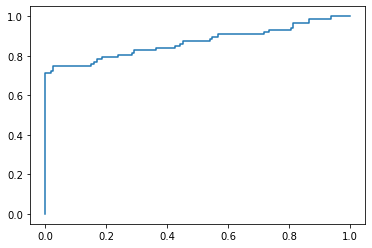

auc:0.8684772657918828


,特征名称,特征重要性
0,换设备次数,0.406744
3,换IP国次数,0.333477
1,支付失败次数,0.190185
2,换IP次数,0.041010
4,交易金额,0.028585


In [10]:
X=df.drop(columns='欺诈标签')
y=df['欺诈标签']
# 数据划分
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
# 模型训练
from xgboost import XGBClassifier
clf=XGBClassifier(n_estimators=100,learning_rate=0.05)
#设置弱学习器的最大迭代次数，或者说弱学习器的个数n_estimators参数为100，以及弱学习器的权重缩减系数learning_rate为0.05
clf.fit(X_train,y_train)
#模型预测
y_pred=clf.predict(X_test)
y_pred_proba=clf.predict_proba(X_test)
# roc 曲线
from sklearn.metrics import roc_curve
fpr,tpr,thres=roc_curve(y_test,y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr,tpr)
plt.show()
# auc
from sklearn.metrics import roc_auc_score
score=roc_auc_score(y_test,y_pred_proba[:,1])
print("auc:{}".format(score))
# 变量重要性
features=X.columns
importances=clf.feature_importances_
importances_df=pd.DataFrame()
importances_df['特征名称']=features
importances_df['特征重要性']=importances
importances_df.sort_values('特征重要性',ascending=False)

In [15]:
# 模型调优
from sklearn.model_selection import GridSearchCV
parameters={'max_depth':[1,3,5],'n_estimators':[50,100,150],'learning_rate':[0.01,0.05,0.1,0.2]}
clf=XGBClassifier()
grid_search=GridSearchCV(clf,parameters,scoring='roc_auc',cv=5)
grid_search.fit(X_train,y_train)
grid_search.best_params_

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...ne,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='roc_auc')

{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100}

In [16]:
# 用最优的模型参数进行训练
clf=XGBClassifier(max_depth=1,n_estimators=100,learning_rate=0.05)
clf.fit(X_train,y_train)
#模型预测
y_pred=clf.predict(X_test)
y_pred_proba=clf.predict_proba(X_test)
# auc
from sklearn.metrics import roc_auc_score
score=roc_auc_score(y_test,y_pred_proba[:,1])
print("auc:{}".format(score))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

auc:0.8563218390804598


调优后 auc:0.8563218390804598

调优前 auc:0.8684772657918828

问什么调优后模型的 auc 还下降了呢?

通常来说，出现这种情况的概率较小，可能是因为数据量较小（如本案例只有1000条数据）
;也可能是因为本案例中使用了交叉验证。AUC值的获取是基于训练集数据，只不过是将训练集数据中的1/K作为测试集数据，该测试集数据并不是真正的测试集数据y_test，这也是参数调优后的结果不如调优前的结果的原因。